## Cargar actividad: Actividad Guiada 3 (Extr): DengAi Predicting Disease Spread - Optimización

### __Nombre:__ Daniel Portugal Revilla
 

__Objetivos:__ Mejorar los resultados de predicción que se han obtenido en la actividad 2 mediante la optimización en la parametrización de los algoritmos utilizados previamente. 

__Técnica a utilizar:__ Técnicas/herramientas de optimización de entre las vistas en clase. 

__Tecnología:__ Para el reto de DengAI se escogió trabajar con Python y sus diversas librerias como:

- Al tener un backgroud de informático, la comodidad y familiaridad de trabajar con python es nativa, así como la ventaja de sus diversas librerías, el poder trabajar en diferentes entornos y plataformas, poder migrar a frameworks como Pyspark con facilidad, etc

### Introducción y definición del problema
La competición le reta a predecir el número de casos de dengue que se notifican cada semana en San Juan (Puerto Rico) e Iquitos (Perú) utilizando los datos ambientales recogidos por diversos organismos del Gobierno Federal de los Estados Unidos. Los datos proporcionados tienen características como la temperatura, la humedad y la precipitación máximas semanales.
El aumento de las precipitaciones también debería contribuir al aumento de los mosquitos y, por lo tanto casos de fiebre del dengue. Con una gran cantidad de datos climáticos y otros factores, vamos a calcular los grandes contribuyentes y predecir los resultados de los datos proporcionados más adelante.



In [26]:
# 0. load data in DataFrame
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import randint as sp_randint
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV


In [14]:

train = pd.read_csv('./Data/dengue_features_train.csv', encoding='utf-8',index_col=['city', 'year', 'weekofyear'])
test = pd.read_csv('./Data/dengue_features_test.csv', encoding='utf-8', index_col=['city', 'year', 'weekofyear'])
labels = pd.read_csv('./Data/dengue_labels_train.csv', encoding='utf-8', index_col=['city', 'year', 'weekofyear'])


In [8]:
labels.head(3)

total_cases
city year weekofyear             
sj   1990 18                    4
          19                    5
          20                    4

In [10]:
train_label = pd.merge(train, labels, on=['city', 'year', 'weekofyear'])
train_label.head(3)

week_start_date  ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  \
city year weekofyear                                                          
sj   1990 18              1990-04-30  0.12260  0.103725  0.198483  0.177617   
          19              1990-05-07  0.16990  0.142175  0.162357  0.155486   
          20              1990-05-14  0.03225  0.172967  0.157200  0.170843   

                      precipitation_amt_mm  reanalysis_air_temp_k  \
city year weekofyear                                                
sj   1990 18                         12.42             297.572857   
          19                         22.82             298.211429   
          20                         34.54             298.781429   

                      reanalysis_avg_temp_k  reanalysis_dew_point_temp_k  \
city year weekofyear                                                       
sj   1990 18                     297.742857                   292.414286   
          19                     298.442857                   293.951429   
          20                     298.878571                   295.434286   

                      reanalysis_max_air_temp_k  ...  \
city year weekofyear                             ...   
sj   1990 18                              299.8  ...   
          19                              300.9  ...   
          20                              300.5  ...   

                      reanalysis_relative_humidity_percent  \
city year weekofyear                                         
sj   1990 18                                     73.365714   
          19                                     77.368571   
          20                                     82.052857   

                      reanalysis_sat_precip_amt_mm  \
city year weekofyear                                 
sj   1990 18                                 12.42   
          19                                 22.82   
          20                                 34.54   

                      reanalysis_specific_humidity_g_per_kg  \
city year weekofyear                                          
sj   1990 18                                      14.012857   
          19                                      15.372857   
          20                                      16.848571   

                      reanalysis_tdtr_k  station_avg_temp_c  \
city year weekofyear                                          
sj   1990 18                   2.628571           25.442857   
          19                   2.371429           26.714286   
          20                   2.300000           26.714286   

                      station_diur_temp_rng_c  station_max_temp_c  \
city year weekofyear                                                
sj   1990 18                         6.900000                29.4   
          19                         6.371429                31.7   
          20                         6.485714                32.2   

                      station_min_temp_c  station_precip_mm  total_cases  
city year weekofyear                                                      
sj   1990 18                        20.0               16.0            4  
          19                        22.2                8.6            5  
          20                        22.8               41.4            4  

[3 rows x 22 columns]

Posteriormente seleccionamos las variables con las que trabajar.

Es importante seleccionar las características cuando se va a resolver un problema mediante KNN ya que muchas variables pueden distorsionar el resultado del algoritmo que está basado en la distancia.

mUtilizaremos la correlación entre cada una de las características y la variable a predecir.

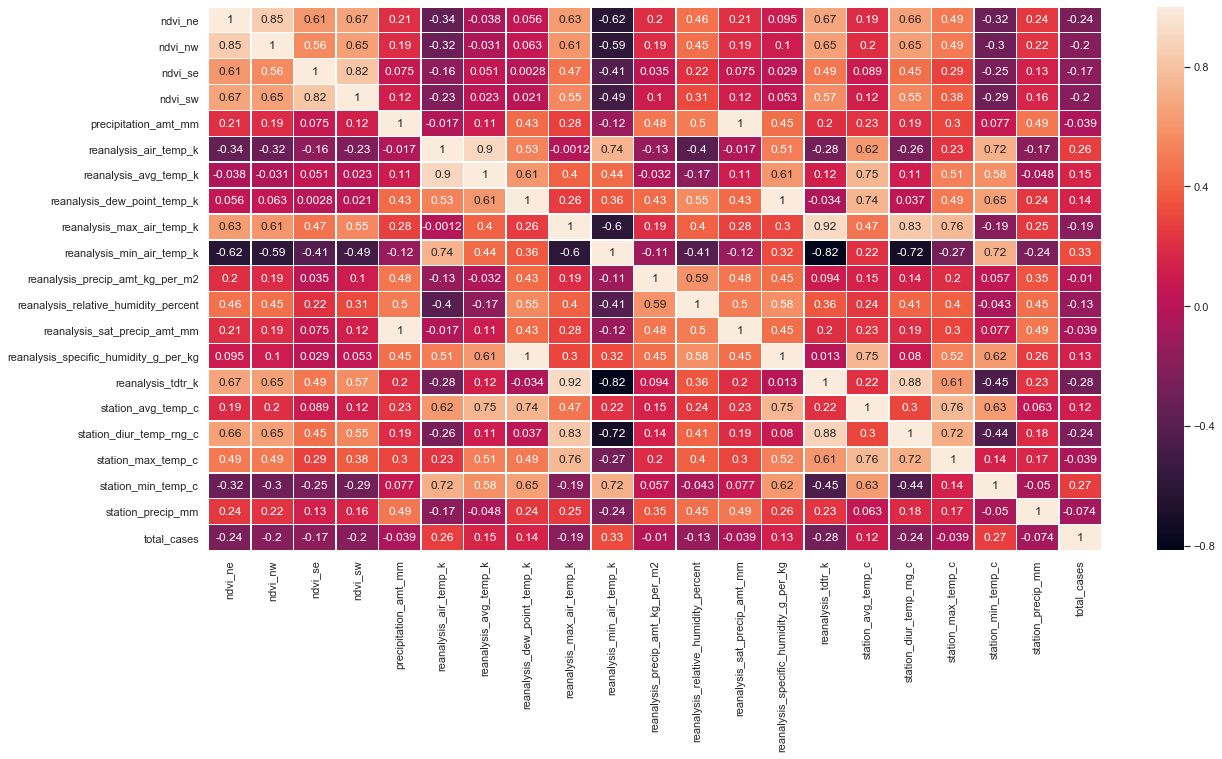

In [15]:
sns.set()
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(train_label.corr(), annot=True, linewidths=.5, ax=ax)

Seleccionamos aquellas caracteristicas que mediante análisis de correlaciones, nos han dado un valor superior a 0.20 o menor -0.20.

In [17]:

pd.set_option('display.max_rows', 1456)
# Seleccionamos las caracteristicas para el df_Train
train_label_a = train_label[['ndvi_ne', 'ndvi_nw', 'ndvi_sw', 'reanalysis_air_temp_k', 'reanalysis_min_air_temp_k', 'reanalysis_tdtr_k', 'station_diur_temp_rng_c', 'station_min_temp_c', 'total_cases']]
train_label_a.head(3) 

ndvi_ne   ndvi_nw   ndvi_sw  reanalysis_air_temp_k  \
city year weekofyear                                                       
sj   1990 18          0.12260  0.103725  0.177617             297.572857   
          19          0.16990  0.142175  0.155486             298.211429   
          20          0.03225  0.172967  0.170843             298.781429   

                      reanalysis_min_air_temp_k  reanalysis_tdtr_k  \
city year weekofyear                                                 
sj   1990 18                              295.9           2.628571   
          19                              296.4           2.371429   
          20                              297.3           2.300000   

                      station_diur_temp_rng_c  station_min_temp_c  total_cases  
city year weekofyear                                                            
sj   1990 18                         6.900000                20.0            4  
          19                         6.371429                22.2            5  
          20                         6.485714                22.8            4

Podemos observar que la columna 'ndvi_ne' posee muchos NaNs, por lo tanto procedemos a la eliminacion de esta columna.

In [18]:
train_label_a = train_label_a.drop('ndvi_ne', axis=1)
train_label_a.head(3)

ndvi_nw   ndvi_sw  reanalysis_air_temp_k  \
city year weekofyear                                              
sj   1990 18          0.103725  0.177617             297.572857   
          19          0.142175  0.155486             298.211429   
          20          0.172967  0.170843             298.781429   

                      reanalysis_min_air_temp_k  reanalysis_tdtr_k  \
city year weekofyear                                                 
sj   1990 18                              295.9           2.628571   
          19                              296.4           2.371429   
          20                              297.3           2.300000   

                      station_diur_temp_rng_c  station_min_temp_c  total_cases  
city year weekofyear                                                            
sj   1990 18                         6.900000                20.0            4  
          19                         6.371429                22.2            5  
          20                         6.485714                22.8            4

In [36]:
# Seleccionamos las caracteristicas para el df_Test
test = test[['ndvi_nw', 'ndvi_sw', 'reanalysis_air_temp_k', 'reanalysis_min_air_temp_k', 'reanalysis_tdtr_k', 'station_diur_temp_rng_c', 'station_min_temp_c']]
test.head(3)

ndvi_nw   ndvi_sw  reanalysis_air_temp_k  \
city year weekofyear                                              
sj   2008 18         -0.018900  0.091200             298.492857   
          19         -0.012400  0.072314             298.475714   
          20          0.126803  0.091529             299.455714   

                      reanalysis_min_air_temp_k  reanalysis_tdtr_k  \
city year weekofyear                                                 
sj   2008 18                              296.4           3.128571   
          19                              296.7           2.571429   
          20                              296.4           4.428571   

                      station_diur_temp_rng_c  station_min_temp_c  
city year weekofyear                                               
sj   2008 18                         7.057143                21.7  
          19                         5.557143                22.2  
          20                         7.785714                22.8

Realizamos una limpieza de los datos para eliminar los NaNs

In [19]:
if train_label_a.isnull().values.any():
  train_label_a = train_label_a.fillna(train_label_a.mean())

train_label_a.isnull().values.any()

False

In [21]:
# Elimnacion de los NaNs con la media
if test.isnull().values.any():
  test = test.fillna(test.mean())

test.isnull().values.any()

False

## 2. PARAMETRO DE OPTIMIZACION

Todo modelos de aprendizaje automático necesitan de cierta parametrización con el fin de que su comportamiento se ajuste mejor a cada problema concreto. Según la naturaleza del modelo este puede tener muchos parámetros y encontrar la mejor combinación de los mismos puede ser tratado como un problema de búsqueda/optimización.

Este problema es denominado habitualmente optimización de hiperparámetros, donde los parámetros del algoritmo se denominan hiperparámetros, mientras que los coeficientes encontrados por el propio algoritmo de aprendizaje se denominan parámetros.

El planteamiento será del de buscar aquella parametrización que ofrezca los resultados de mayor calidad (con respecto a las métricas establecidas) y de mayor robustez.

Utilizaremos la libreria de machine learning Scikit-learn el cual proporciona diferentes herramientas para que la optimización de estos hiperparámetros pueda ser lo más sencilla posible. En concreto ofrece dos alternativas, la búsqueda en cuadrícula (grid search) y la búsqueda aleatoria (RandomSearch)

In [22]:
# reseteamos el index con el fin de no evitar problemas en la validación cruzada
train_label_a.reset_index(drop = True, inplace = True)

Para utilizar estas herramientas de búsqueda, primero necesitamos crear el conjunto de parámetros a muestrear durante el proceso de optimización.

Y crear (construir) el elemento que va a ser nuestro regresor

In [27]:
regressor = RandomForestRegressor()

### GridSearch

La búsqueda en cuadrícula es un enfoque de ajuste de parámetros que permite construir y evaluar metódicamente un modelo para cada combinación de parámetros de algoritmo especificados en una cuadrícula.

In [28]:
# Se ha usado 5 arboles en random forest para mayor precision en la optimizacion
param_dist = {"n_estimators": [4, 8, 16, 32, 64, 128],   # Numero de arboles en random forest
              "max_features": ['auto', 'sqrt'],          # Número de características a considerar en cada división
              "max_depth": [8, 4, 2],                    # Número máximo de niveles en el árbol. 
              "min_samples_split": [2, 4, 6],            # Número mínimo de muestras requeridas para dividir un nodo
              "min_samples_leaf": [8, 12, 16],           # Número mínimo de muestras requeridas en cada nodo hoja
              "bootstrap": [True, False]                 # Método de selección de muestras para entrenar cada árbol.
            }

In [30]:
# Creamos nuestra estructura de busqueda por validacion cruzada. cv = intervalo de distribucion cruzada
# Entre mayor sea el numero de cross validation (cv), mejor es el aprendizaje
grid_regres = GridSearchCV(estimator = regressor, param_grid= param_dist, cv = 10)

# Ajustar el modelo de busqueda aleatorio
grid_regres.fit(X = train_label_a.drop(['total_cases'], axis=1), 
                           y = train_label_a['total_cases']
               )

C:\Users\danie\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'bootstrap': [True, False], 'm

In [31]:
# Elegimos el mejor estimador
grid_regres.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=8, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=8, n_jobs=None,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [34]:
train_label_a.head()

,ndvi_nw,ndvi_sw,reanalysis_air_temp_k,reanalysis_min_air_temp_k,reanalysis_tdtr_k,station_diur_temp_rng_c,station_min_temp_c,total_cases
0,0.103725,0.177617,297.572857,295.9,2.628571,6.900000,20.0,4
1,0.142175,0.155486,298.211429,296.4,2.371429,6.371429,22.2,5
2,0.172967,0.170843,298.781429,297.3,2.300000,6.485714,22.8,4
3,0.245067,0.235886,298.987143,297.0,2.428571,6.771429,23.3,3
4,0.262200,0.247340,299.518571,297.5,3.014286,9.371429,23.9,6


In [37]:
# Elegir el mejor
best_grid = grid_regres.best_estimator_

# Ajuste y predicción
best_grid.fit(X = train_label_a.drop(['total_cases'], axis=1), y = train_label_a['total_cases'])
y_pred = best_grid.predict(X = test) 


Guardamos fichero de resultado en disco

In [42]:
# round the result and cast to int
res = np.rint(y_pred)      # round
res = res.astype(int)      # cast to int
# generate output
submission = pd.DataFrame(res, index=test.index, columns=['total_cases'])


In [45]:
submission.to_csv('AG03_V1_GridSearch.csv')

<img src="https://i.ibb.co/qy8Z1sq/gridsearch.png">

### Boosting
Vamos a utilizar las mismas técnicas para optimizar los párametros de los algortimos basados en Boosting.

En primer lugar Adaboost, con parámetros como el número de árboles, el coeficiente de aprendizaje y la función de pérdida.

In [46]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

param_dist = {
 "n_estimators": [4, 8, 16, 32, 64, 128],
 "learning_rate" : [0.01,0.05,0.1],
 "loss" : ['linear', 'square', 'exponential']
 }
grid_ada = GridSearchCV(AdaBoostRegressor(DecisionTreeRegressor(criterion='mae')),
                        param_grid = param_dist, cv=10)

grid_ada.fit(X = train_label_a.drop(['total_cases'], axis=1),y = train_label_a['total_cases'])

best_ada = grid_ada.best_estimator_
print (best_ada)
# fit and predict
best_ada.fit( X = train_label_a.drop(['total_cases'], axis=1), y = train_label_a['total_cases'])
y_pred = best_ada.predict(X = test)


C:\Users\danie\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mae',
                                                       max_depth=None,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort=False,
                                                       random_state=None,
                                                       splitter='best'),
                  learning_rate=0.01, loss='exponential', n_estimators=128,
                

In [48]:
res = np.rint(y_pred) # round
res = res.astype(int) # cast to int

# generate output
submission = pd.DataFrame(res, index=test.index, columns=['total_cases'])


In [49]:
submission.to_csv('AG03_V1_Boosting.csv')

<img src=https://i.ibb.co/MCvkqsH/boosting.png>

## RandomizedSearch

Para utilizar RandomizedSearchCV, primero necesitamos crear el conjunto de parámetros a muestrear durante el proceso de optimización.

In [50]:
param_dist = {"n_estimators": [4, 8, 16, 32, 64, 128], # Number of trees in random forest
              "max_features": ['auto', 'sqrt'], # Number of features to consider at every split
              "max_depth": [16, 12,8,4, 2,None], # Maximum number of levels in tree
              "min_samples_split": sp_randint(2, 50), #  Minimum number of samples required to split a node
              "min_samples_leaf": sp_randint(1, 50), # Minimum number of samples required at each leaf node
              "bootstrap": [True, False], # Method of selecting samples for training each tree
              "criterion": ["mse", "mae"]}

En cada iteración, el algoritmo elegirá una combinación diferente de las características. Si se probaran de forma exhaustiva todas las características el problema se volvería muy costoso computacionalmente. Al menos al utilizar búsqueda aleatoria se seleccionará al azar una muestra de las mismas para buscar en un reducido pero significativo rango de valores.

Los argumentos más importantes en RandomizedSearchCV son n_iter, que controla el número de combinaciones diferentes a probar, y cv, que es el número de cruces a usar para la validación cruzada. Más iteraciones cubrirán un espacio de búsqueda más amplio y más cruces de cv reducen las posibilidades de sobreaprendizaje, pero al aumentar cada una de ellas se incrementará el tiempo de ejecución.

Vamos a ejecutarla utilizando la validación cruzada (5-fold) y posteriormente busca entre 100 combinaciones diferentes de entre las especificadas

In [51]:
rnd_regres = RandomizedSearchCV(estimator = regressor, 
                                param_distributions = param_dist, 
                                n_iter = 100, cv = 10, random_state=0, n_jobs = -1)
# Fit the random search model
rnd_regres.fit(X = train_label_a.drop(['total_cases'], axis=1), 
               y = train_label_a['total_cases'] )

C:\Users\danie\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=10, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_st...


In [52]:
rnd_regres.best_params_

{'bootstrap': True,
 'criterion': 'mae',
 'max_depth': 16,
 'max_features': 'sqrt',
 'min_samples_leaf': 41,
 'min_samples_split': 38,
 'n_estimators': 4}

Una vez que hemos identificado la mejor parametrización vamos a pasar a hacer una ejecución del modelo y vamos graficar sus resultados.
Recordamos que al final del paso 1 hemos dividido en entrenamiento/tuneado y test
Posteriormente, vamos a ejecutar el modelo con la mejor parametrización que hayamos obtenido anteriormente

In [53]:
# choose the best
best_random = rnd_regres.best_estimator_
# fit and predict
best_random.fit(X = train_label_a.drop(['total_cases'], axis=1), y = train_label_a['total_cases'])
y_pred = best_random.predict(X = test)

Guardamos fichero de resultado en disco

In [54]:
res = np.rint(y_pred) # round
res = res.astype(int) # cast to int

# generate output
submission = pd.DataFrame(res, index=test.index, columns=['total_cases'])

In [58]:
test.head()

ndvi_nw   ndvi_sw  reanalysis_air_temp_k  \
city year weekofyear                                              
sj   2008 18         -0.018900  0.091200             298.492857   
          19         -0.012400  0.072314             298.475714   
          20          0.126803  0.091529             299.455714   
          21         -0.019867  0.125686             299.690000   
          22          0.039833  0.075914             299.780000   

                      reanalysis_min_air_temp_k  reanalysis_tdtr_k  \
city year weekofyear                                                 
sj   2008 18                              296.4           3.128571   
          19                              296.7           2.571429   
          20                              296.4           4.428571   
          21                              296.9           4.342857   
          22                              297.3           3.542857   

                      station_diur_temp_rng_c  station_min_temp_c  
city year weekofyear                                               
sj   2008 18                         7.057143                21.7  
          19                         5.557143                22.2  
          20                         7.785714                22.8  
          21                         6.271429                24.4  
          22                         7.085714                23.3

In [55]:
submission.to_csv('AG03_V3_RandomizedSearch.csv')

<img src="https://i.ibb.co/Gxr0f0Y/Randomized-Search.png">